# Yolo to Detect on Image

In [1]:
import cv2
import numpy as np

from utils.datasets import letterbox

import torch
from torchvision import transforms
from utils.general import non_max_suppression, non_max_suppression_kpt

from utils.datasets import letterbox

C:\projects\cv2\cv2_kamera\custom_yolov7\envv7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_model(weights):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = torch.load(weights, map_location=device)['model']
    # Put in inference mode
    #model.float().eval()
    model.eval()

    if torch.cuda.is_available():
        # half() turns predictions into float16 tensors
        # which significantly lowers inference time
        model.half().to(device)
    return model



def run_inference(image, model):
    #image = cv2.imread(url) # shape: (480, 640, 3)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Resize and pad image
    image = letterbox(image, 640, stride=32)[0] # shape: (768, 960, 3)

    
    # Apply transforms
    image = transforms.ToTensor()(image) # torch.Size([3, 768, 960])
    image = image.type(torch.cuda.HalfTensor)
    # Turn image into batch
    image = image.unsqueeze(0) # torch.Size([1, 3, 768, 960])
    output, _ = model(image) # torch.Size([1, 45900, 57])
    return output, image 

In [3]:
labels = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]

In [18]:
labels = ['Tempolimit','Verkehrsschild']

In [19]:
#frame = cv2.imread("img1.jpeg")
frame = cv2.imread("pic70.png")
model = load_model('best.pt')

#model = load_model('yolov7.pt') #TODO Warum geht hier kein normales Yolo?
#https://github.com/ultralytics/yolov5/issues/6948


output, image = run_inference(frame, model) # Bryan Reyes on Unsplash
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
print("output: ",output)
rect = non_max_suppression_kpt(output, 
                                 0.5,
                                 0.45 )
print("rect: ",rect)
d = []
titles = []
print("")
print("For Loop objects in rect[0]:")
for i in rect[0]:
    print(i)
    if i[5] == 0: #Klasse 0 ist hier verkehrsschild
        print("rotes rundes Verkehrsschild detected")
    else:
        print("anderes Verkehrsschild")
    x1 = int(i[0])
    y1 = int(i[1])
    x2 = int(i[2])
    y2 = int(i[3])
    print("x1: ",x1)
    print("y1: ",y1)
    print("x2: ",x2)
    print("y2: ",y2)
    detection = cv2.cvtColor(nimg[y1:y2,x1:x2],cv2.COLOR_BGR2RGB)
    d.append(detection)
    titles.append(labels[int(i[5])])
    nimg = cv2.rectangle(nimg, (x1,y1), (x2,y2), (255,0,0),1)
    try:
        cv2.putText(nimg, labels[int(i[5])], (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1, cv2.LINE_AAA)
    except:
        print("error accessing labels")

cv2.imshow("Picture",nimg)
cv2.waitKey()
cv2.destroyAllWindows() 

output:  tensor([[[5.86719e+00, 4.41406e+00, 1.22344e+01,  ..., 2.85950e-02, 1.60767e-01, 8.15430e-01],
         [1.05469e+01, 4.90625e+00, 1.61875e+01,  ..., 4.05273e-02, 2.66846e-01, 4.75830e-01],
         [1.72188e+01, 3.92578e+00, 1.95781e+01,  ..., 7.35474e-02, 3.05664e-01, 4.08447e-01],
         ...,
         [5.58500e+02, 3.38500e+02, 4.05500e+02,  ..., 3.37219e-02, 4.09241e-02, 3.10822e-02],
         [5.90500e+02, 3.38500e+02, 4.06250e+02,  ..., 3.35999e-02, 4.06799e-02, 3.10211e-02],
         [6.22500e+02, 3.39000e+02, 3.60500e+02,  ..., 3.55530e-02, 4.21753e-02, 3.17993e-02]]], device='cuda:0', dtype=torch.float16)
rect:  [tensor([[464.25000, 209.12500, 482.25000, 227.37500,   0.94922,   0.00000],
        [115.31250, 206.75000, 134.75000, 226.25000,   0.93896,   0.00000],
        [411.75000, 141.62500, 436.25000, 163.62500,   0.89258,   1.00000]], device='cuda:0')]

For Loop objects in rect[0]:
tensor([464.25000, 209.12500, 482.25000, 227.37500,   0.94922,   0.00000], device=

# Plot Detections in Notebook

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_images(images, titles=None, vert=True):
    if vert:
        fig, ax = plt.subplots(nrows=len(images), figsize=(10,len(images)*4))
    else:
        fig, ax = plt.subplots(ncols=len(images), figsize=(len(images)*4,10))
    show_gray=False
    if len(images)>1:
        for idx, image in enumerate(images):
            if show_gray:
                ax[idx].imshow(image, cmap='gray')
            else:
                ax[idx].imshow(image)
            ax[idx].axis(False)
            if(titles != None):
                ax[idx].set_title(titles[idx])
    else:
        if show_gray:
            ax.imshow(images[0], cmap='gray')
        else:
            ax.imshow(images[0])
        ax.axis(False)
        if(titles != None):
            ax.set_title(titles[idx])
    return

In [20]:
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
nimg = cv2.cvtColor(nimg,cv2.COLOR_BGR2RGB)

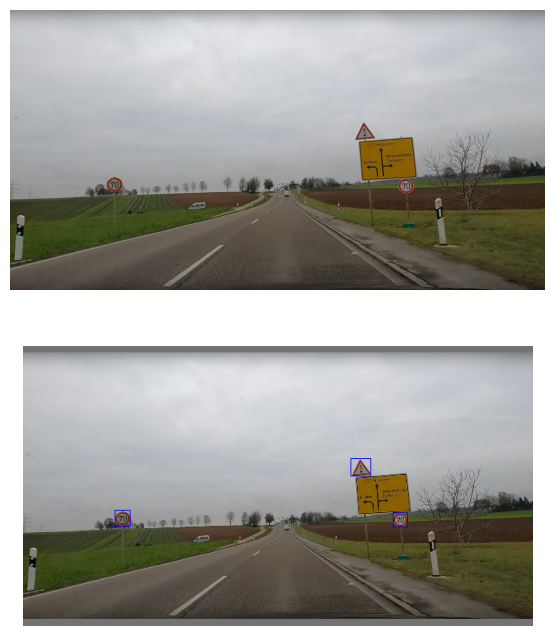

In [21]:
show_images([frame,nimg])

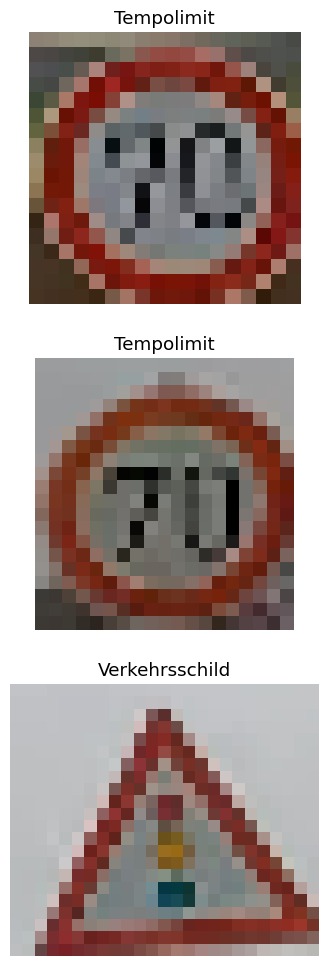

In [22]:
show_images(d,titles)